In [3]:
import numpy as np
import scipy.stats as stats
import csv
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import gensim as gs 
from gensim import corpora, models, similarities
import logging
import multiprocessing
import pickle


logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


np.random.seed(0)

# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline

# this line makes plots prettier on mac retina screens. If you don't have one it shouldn't do anything.
%config InlineBackend.figure_format = 'retina'

cores = multiprocessing.cpu_count()

# Hotel Reviews: What is real?
<h1>Problem Statement</h1>
When someone goes on to plan a stay, they tend to use online reviews to base their decision; However, there are usually a range of opinions so how can we tell if a certain review is fake/real or just plain bad luck? Thus the problem statement is to detect fradulent reviews for people are surfing hotel booking sites. 

<h1>Goals </h1>
When someone goes on to plan a stay, they tend to use online reviews to base their decision; However, there are usually a range of opinions so how can we tell if a certain review is fake/real or just plain bad luck? Thus the problem statement is to detect fradulent reviews for people are surfing hotel booking sites. 

The end-goal would be to have a website where users can copy and paste a hotel review and a result would be returned - either a probability that the reivew is fake/true or a color-coded general response if the review was trustworthy. 

Furthermore, there is a core labelled corpus of 1600 hotel reviews, and 512k 
unlabelled hotel reviews. I would like to utilize these unlabelled reviews in a semi-supervised fashion. 

<h1>Metrics </h1>
Given our end-goal in mind, I felt that users would appreciate precision more; if a high number of reviews they put into the review app returned false, they might get turned off by the high amount of false positives and it does not aid their selection process. They might even not trust the system at all. Therefore F1 or precision score would be the metrics. We aim to hit 71% to 74% precision with good f1 score. 

<h1>Findings</h1>
<h2>*Supervised Learning*</h2>
<table>
    <tr>
        <th>Classifier</th>
        <th>Precision</th>
    </tr>
    <tr>
        <td>Decision Tree</td>
        <td>0.5942</td>
    </tr>
    <tr>
        <td>Logistic Regression</td>
        <td>0.6882</td>
    </tr>
    <tr>
        <td>Gaussian Naive Bayes</td>
        <td>0.7712</td>
    </tr>
    <tr>
        <td>SVM</td>
        <td>0.7312</td>
    </tr>
    <tr>
        <td>XGBoost</td>
        <td>0.8469</td>
    </tr>
</table>
    
<h2>*SemiSupervised Learning*</h2>
Several different approaches were used. 
<table>
    <tr>
        <th>Clustering</th>
        <th>Results</th>
    </tr>
    <tr>
        <td>Pseudo Labelling</td>
        <td>Slightly better than chance</td>
    </tr>
    <tr>
        <td>sklearn.LabelSpreading</td>
        <td>Recall: 0.5347, Precision: 0.6276</td>
    </tr>
    <tr>
        <td>Hierarchical Clustering</td>
        <td>Coph_Distance: 0.5580</td>
    </tr>
    <tr>
        <td>LocalitySensitiveHashing</td>
        <td>Slightly better than chance</td>
    </tr>
    <tr>
        <td>DBSCAN</td>
        <td>Slightly better than chance</td>
    </tr>
    <tr>
        <td>Recursive KMeans</td>
        <td>Recall: 0.58, Precision: 0.53
    </tr>
    <tr>
        <td>Contrastive Pessimistic Likelihood Estimation (CPLE)</td>
        <td>As good as baseline model (XGBoost)
    </tr>
    <tr>
        <td>CPLE-SVM (RBF kernel)</td>
        <td>Slightly better than chance</td>
    </tr>
</table>

<h1>Risks/Limitations/Assumptions</h1>
<h2>*Many language libraries black boxes*</h2>
There are quite many NLP libraries available (NLTK, gensim, etc.) which means we have to try substanial number of libraries to assess their results.

Each run of the algorithm takes up a significant amount of time, thus more time is needed so a CUDA-specific libray (TensorFlow) could be used.However this would mean even more time spent on on-boarding. 

There is a assumption that there actually exists some pattern or trend that exists in both truthful and fake reviews. 
<h2>*Data Issues & Assumptions*</h2>
There is an assumption that there are common trends between labelled and unlabelled data that would show up and thus allow us to cluster them and potentially improve the supervised training. However this may not be, as one collection was generated mostly by MTurk and TripAdvisor and one was collected from European hotels, potentially with just some overlap. 

After generating all the vectors from doc2vec, lda, and other algorithms, the feature vector is of a very high dimension, and not easy to flatten into 2-D space for visualization (PCA did not produce features with a lot of energy), limiting the intuition for the data. Also, the model needed all of the features to obtain the best supervised result. 

<h2>*SemiSupervised algorithm Issues*</h2>
Arising from the previous issue of assumed trends, the semi supervised training depends heavily on the trends. However, SVM 


# EDA 
<h1>Variables of Interest</h1>
<h1>Outliers</h1
<h1>Data Imputation</h1>

In [4]:
df = pd.read_csv('./input/deceptive-opinion.csv')

In [5]:
df.head(4)

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...


In [6]:
df['hotel'].unique()

array(['conrad', 'hyatt', 'omni', 'fairmont', 'sheraton', 'knickerbocker',
       'homewood', 'swissotel', 'ambassador', 'affinia', 'hardrock',
       'talbott', 'hilton', 'james', 'monaco', 'sofitel', 'palmer',
       'intercontinental', 'allegro', 'amalfi'], dtype=object)

In [7]:
df['source'].unique()

array(['TripAdvisor', 'MTurk', 'Web'], dtype=object)

In [8]:
# pd.DataFrame(map(len,df['text'])).describe()
pd.DataFrame([len(x) for x in df['text']]).describe()

,0
count,1600.000000
mean,806.391250
std,467.260647
min,151.000000
25%,487.000000
50%,700.000000
75%,987.500000
max,4159.000000


In [9]:
df['deceptive'].value_counts()

truthful     800
deceptive    800
Name: deceptive, dtype: int64

In [10]:
df.loc[1,'text']

'Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n'

In [43]:
df2 = pd.read_csv('./input/Hotel_Reviews.csv')
data2 = df2[~df2['lat'].isnull()]
data2 = data2.reset_index(drop=True)

In [44]:
print(data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512470 entries, 0 to 512469
Data columns (total 17 columns):
Hotel_Address                                 512470 non-null object
Additional_Number_of_Scoring                  512470 non-null int64
Review_Date                                   512470 non-null object
Average_Score                                 512470 non-null float64
Hotel_Name                                    512470 non-null object
Reviewer_Nationality                          512470 non-null object
Negative_Review                               512470 non-null object
Review_Total_Negative_Word_Counts             512470 non-null int64
Total_Number_of_Reviews                       512470 non-null int64
Positive_Review                               512470 non-null object
Review_Total_Positive_Word_Counts             512470 non-null int64
Total_Number_of_Reviews_Reviewer_Has_Given    512470 non-null int64
Reviewer_Score                                512470 non-null flo

In [45]:
data2.head(3).T

,0,1,2
Hotel_Address,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...
Additional_Number_of_Scoring,194,194,194
Review_Date,8/3/2017,8/3/2017,7/31/2017
Average_Score,7.7,7.7,7.7
Hotel_Name,Hotel Arena,Hotel Arena,Hotel Arena
Reviewer_Nationality,Russia,Ireland,Australia
Negative_Review,I am so angry that i made this post available...,No Negative,Rooms are nice but for elderly a bit difficul...
Review_Total_Negative_Word_Counts,397,0,42
Total_Number_of_Reviews,1403,1403,1403
Positive_Review,Only the park outside of the hotel was beauti...,No real complaints the hotel was great great ...,Location was good and staff were ok It is cut...


In [46]:
all_unlabelled = []
for i,line in enumerate(data2['Negative_Review']):
    inp = ""
    if (np.random.randint(0,2) == 0):
        inp = data2.loc[i,'Negative_Review'] + ' ' + data2.loc[i,'Positive_Review']
    else:
        inp = data2.loc[i,'Positive_Review'] + ' ' + data2.loc[i,'Negative_Review']
    all_unlabelled.append(inp)

data2['All_Text'] = pd.Series(all_unlabelled)


In [47]:
data2[['All_Text','Negative_Review','Positive_Review']].head(10)

,All_Text,Negative_Review,Positive_Review
0,I am so angry that i made this post available...,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...
1,No real complaints the hotel was great great ...,No Negative,No real complaints the hotel was great great ...
2,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...
3,My room was dirty and I was afraid to walk ba...,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...
4,Amazing location and building Romantic settin...,You When I booked with your company on line y...,Amazing location and building Romantic setting
5,Good restaurant with modern design great chil...,Backyard of the hotel is total mess shouldn t...,Good restaurant with modern design great chil...
6,The room is spacious and bright The hotel is ...,Cleaner did not change our sheet and duvet ev...,The room is spacious and bright The hotel is ...
7,Good location Set in a lovely park friendly s...,Apart from the price for the brekfast Everyth...,Good location Set in a lovely park friendly s...
8,No Positive Even though the pictures show ver...,Even though the pictures show very clean room...,No Positive
9,The room was big enough and the bed is good T...,The aircondition makes so much noise and its ...,The room was big enough and the bed is good T...


In [17]:
h_cluster = pickle.load(open('./input/h_cluster.p','rb'))
true_fake_vec = pd.read_csv('./csv/true_fake_vec.csv', index_col=False)
true_fake_vec.drop(['Unnamed: 0'], axis=1, inplace=True)
true_fake_vec['h_cluster'] = h_cluster

In [22]:
true_clean = pickle.load(open('./input/true_corpus_clean2.p','rb'))
fake_clean = pickle.load(open('./input/fake_corpus_clean2.p','rb'))
true2 = [' '.join(a) for a in true_clean]
fake2 = [' '.join(a) for a in fake_clean]
all_clean = pd.concat([pd.DataFrame(true2,columns=['deception']), pd.DataFrame(fake2, columns=['deception'])], axis=0, ignore_index=True)

In [6]:
from wordcloud import WordCloud
def gen_cloud(catno, more_than, half_pt):
    if more_than:
        words = ''.join(df[(true_fake_vec.h_cluster == catno) & (df.index > half_pt)].deception)
    else:
        words = ''.join(df[(true_fake_vec.h_cluster == catno) & (df.index < half_pt)].deception)
    wordcloud = WordCloud().generate(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(words)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

(-0.5, 399.5, 199.5, -0.5)

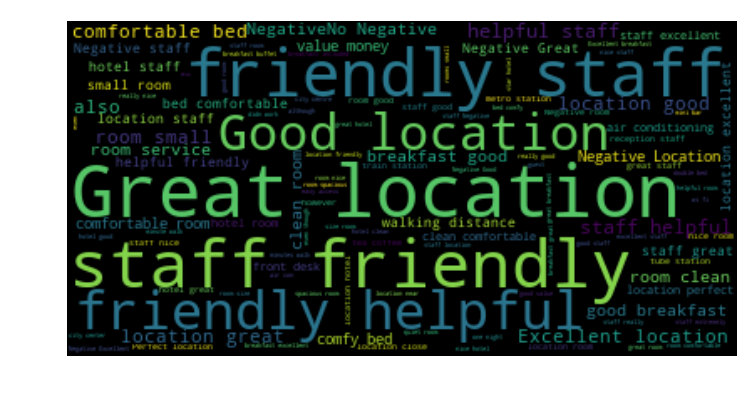

In [49]:
# gen_cloud(3,True,799)
unlabelled_words= ''.join(data2.All_Text)
wordcloud = WordCloud().generate(unlabelled_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [10]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [14]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(true_fake_vec, 'ward')

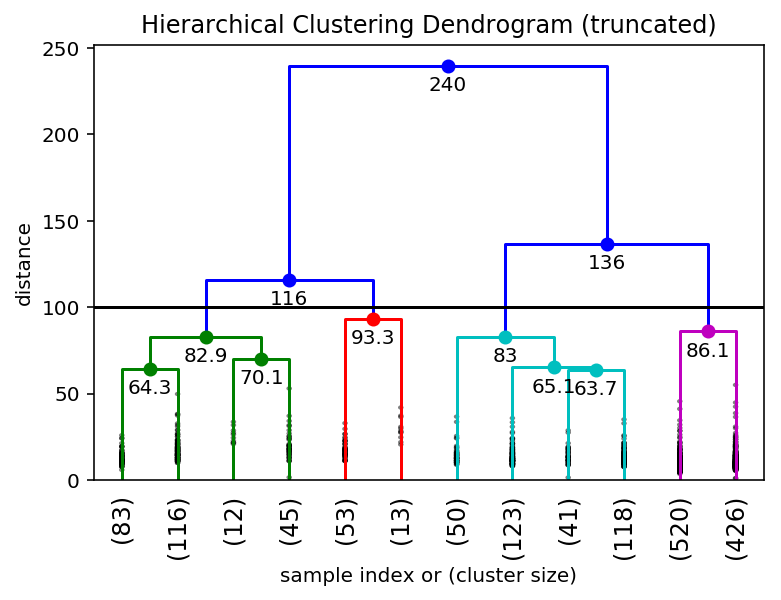

In [15]:
max_d = 100  # max_d as in max_distance

fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [50]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
countvec = CountVectorizer()
wordcount = countvec.fit_transform(all_clean.deception[(true_fake_vec.h_cluster == 1) & (df.index > 799)])
wkeys = list(countvec.get_feature_names())
counts = wordcount.sum(axis=0).A1
freq_dist = pd.DataFrame.from_dict(dict(zip(wkeys,counts)),orient='index').sort_values([0], ascending=False)
freq_dist.rename({0:'freq'},axis='columns',inplace=True)

In [51]:
tfidf = TfidfVectorizer()
tfidfcount = tfidf.fit_transform(all_clean.deception[(true_fake_vec.h_cluster == 1) & (df.index > 799)])
tfkeys = list(tfidf.get_feature_names())
tfcounts = tfidfcount.sum(axis=0).A1
tf_dist =  pd.DataFrame.from_dict(dict(zip(tfkeys,tfcounts)),orient='index').sort_values([0], ascending=False)
tf_dist.rename({0:'tfidf'}, axis='columns', inplace=True)

In [52]:
pd.concat([freq_dist,tf_dist],axis=1).sort_values(['tfidf'], ascending=False).head(15)

,freq,tfidf
hotel,389,10.634241
room,267,7.540338
stay,89,4.222113
chicago,75,3.241926
one,63,3.157702
just,55,2.941850
staff,53,2.836165
rooms,50,2.695872
also,45,2.551924
time,39,2.297544


# Statistical Analysis
<h1>Model Selection</h1>
We try to create as much features from plain text thus we 

<h1>Implementation</h1>
<ol>
    <li>Preprocess</li>
    <ol>
        <li>Bigram, Trigram creation using gensim</li>
        <li>Stopword removal, using capitalized, and bigram stopwords</li>
        
    </ol>
    <li>Generate VADER using raw text</li>
    <li>Generate EMPATH using raw text</li>
    <ol>
        <li>with multiprocessing wrapper on the cloud to half the generation time</li>
    </ol>
    <li>Generate LDA vectors using cleaned,bigram data</li>
    <li>Tf-IDF/Word Count did not improve results</li>
    <ol>
        <li>100 topics, 400 chunksize</li>
    </ol>
    <li>Generate Supervised Model</li>
    <ol>
        <li>Gaussian NaiveBayes, Decision Tree, SVM, XGBoost, Logistic Regression</li>
        <li>GridSearch with XGBoost</li>
    </ol>
    <li>Generate SemiSupervised Model</li>
    
</ol>
    
<h1>Evaluation</h1>
<ol>
    <li>Supervised models worked well</li>
    <li>sklearn.labelpropagation did not work at all</li>
    <li>Implemented my own Pseudo-Labelling</li>
    <li>CPLELearner was a 3rd party library developed based on Loog, 2015</li>
    <li>CPLELearner also has a self-learner model</li>
    <li>No clear clustering from unsupervised hierarchical model,DBSCAN,</li>
    <li>Locality-sensitive Hashing had no clear effect</li>
    <li>Semi-supervised recursive Kmeans developed based on 
</ol>

<h1>Inference</h1>
From the raw unlabelled word cloud and the wordcount of labelled corpus, there seems to be quite a lot of difference just in vocabulary, and corpus structure. 

<h1>Future Work</h1>
Generation of word embeddings by feeding in doc2vec into a LSTM. LSTMs have been known to perform favorably for NLP tasks.
Use surrounding metadata to build a better idea of fake reviews (Consistency, scores, activity profile, user profile) 
gensim tokenizer removes special characters during tokenization, which can be some form of indicator
Some way to determine spelling errors 